# Intra - Inter connectivity

Create the first figure, that tries to replicate the correlation between intra and inter connectivity
described in existing papers

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statannotations.Annotator import Annotator
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [51]:
sns.set(style='darkgrid', context='paper', palette='Set1', font="serif")

In [52]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<3", "EDSS>=3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()

In [53]:
print(len(df_merged))
x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "SC_spl_full"
y2 = "SC_eff_full"


tidy = (
    df_merged[["Comm_ratio", "CC_ratio_area", "SC_spl_full", "SC_eff_full"]].stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'val'}) # rename the unnamed column
)

print(tidy.head())


697
   level_0        level_1         val
0        0     Comm_ratio    0.010277
1        0  CC_ratio_area    0.221946
2        0    SC_spl_full    0.014275
3        0    SC_eff_full  108.307811
4        1     Comm_ratio    0.010640


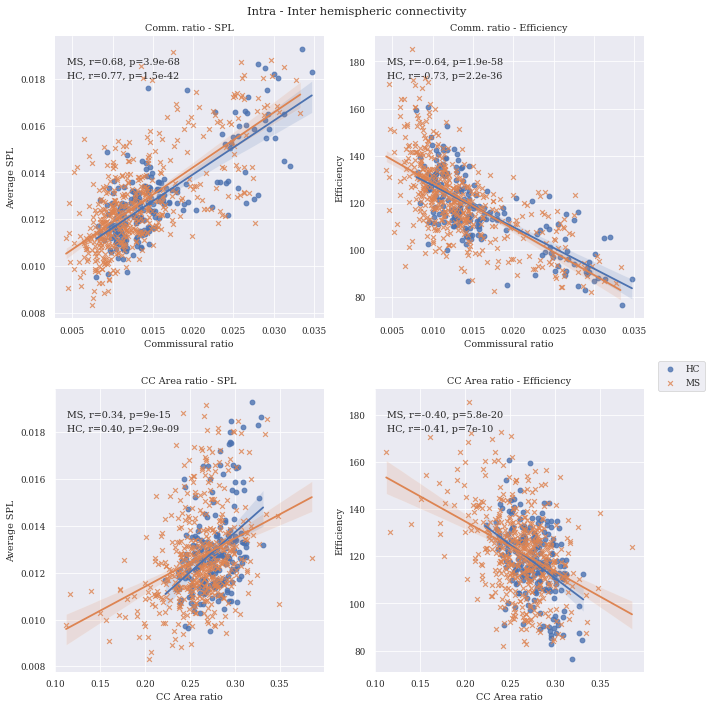

In [73]:
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.05
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label}, ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)

# results = smf.ols(f'{x} ~ C(CENTER)', data=df_merged).fit()
# df_merged[f"{x}_C"] = results.resid + results.params.Intercept
# results = smf.ols(f'{y} ~ C(CENTER)', data=df_merged).fit()
# df_merged[f"{y}_C"] = results.resid + results.params.Intercept

x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "SC_spl_full"
y2 = "SC_eff_full"

# build 4 dataframes manually, with columns intra/inter which means the variable intra/inter for that 
df_x1_y1 = pd.DataFrame({"inter": df_merged[x1].values, "intra": df_merged[y1].values, "disease": df_merged["disease"].values})
df_x1_y1["inter_name"] = x1
df_x1_y1["intra_name"] = y1

df_x1_y2 = pd.DataFrame({"inter": df_merged[x1].values, "intra": df_merged[y2].values, "disease": df_merged["disease"].values})
df_x1_y2["inter_name"] = x1
df_x1_y2["intra_name"] = y2

df_x2_y1 = pd.DataFrame({"inter": df_merged[x2].values, "intra": df_merged[y1].values, "disease": df_merged["disease"].values})
df_x2_y1["inter_name"] = x2
df_x2_y1["intra_name"] = y1

df_x2_y2 = pd.DataFrame({"inter": df_merged[x2].values, "intra": df_merged[y2].values, "disease": df_merged["disease"].values})
df_x2_y2["inter_name"] = x2
df_x2_y2["intra_name"] = y2

# concatenate the four dataframes
df_intra_inter = pd.concat([df_x1_y1, df_x1_y2, df_x2_y1, df_x2_y2])

g = sns.lmplot(data=df_intra_inter, x="inter", y="intra", hue="disease", hue_order=["HC", "MS"], row="inter_name", col="intra_name", facet_kws={"sharex":False, "sharey":False}, scatter_kws={"alpha":0.8}, legend=False, legend_out=True, markers=["o", "x"], palette="deep")
g.map_dataframe(annotate, "inter", "intra", multihue=True)

## Create the correct titles

fig = g.fig
fig.suptitle("Intra - Inter hemispheric connectivity")
a1 = fig.axes[0]
a1.set_title("Comm. ratio - SPL")
a1.set_xlabel("Commissural ratio")
a1.set_ylabel("Average SPL")

a2 = fig.axes[1]
a2.set_title("Comm. ratio - Efficiency")
a2.set_xlabel("Commissural ratio")
a2.set_ylabel("Efficiency")

a3 = fig.axes[2]
a3.set_title("CC Area ratio - SPL")
a3.set_xlabel("CC Area ratio")
a3.set_ylabel("Average SPL")

a4 = fig.axes[3]
a4.set_title("CC Area ratio - Efficiency")
a4.set_xlabel("CC Area ratio")
a4.set_ylabel("Efficiency")

plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', borderaxespad=0)
plt.tight_layout()

plt.savefig("/home/extop/GERARD/PAPERS/PAPER_COBRA/FIGURES/FIg1_intrainter.pdf", dpi=300)

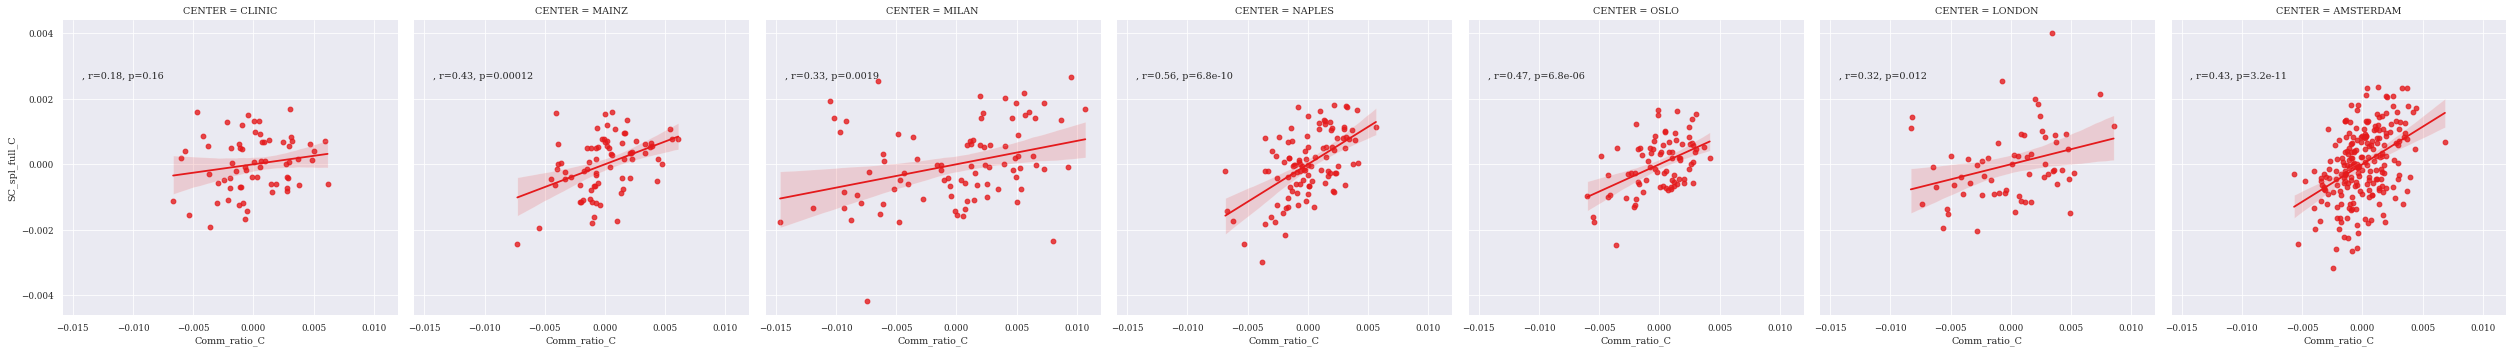

In [55]:
variable_to_plot = "Comm_ratio"
cc = "SC_spl_full"

results = smf.ols(f'{variable_to_plot} ~ C(CENTER)', data=df_merged).fit()
df_merged[f"{variable_to_plot}_C"] = results.resid

results = smf.ols(f'{cc} ~ C(CENTER)', data=df_merged).fit()
df_merged[f"{cc}_C"] = results.resid

df_merged['disease'] = np.where((df_merged['GROUP']== 'HC'), "HC", "MS")
df_merged_hc = df_merged[df_merged.disease == "HC"]
g = sns.lmplot(data=df_merged, x=f"{variable_to_plot}_C", y=f"{cc}_C", col="CENTER")
g.map_dataframe(annotate, f"{variable_to_plot}_C", f"{cc}_C", multihue=False)